In [1]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [2]:
# Namespace for the memory to save
user_id = "1"

namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

In [3]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [4]:
# Metatdata 
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': 'aff362bc-3b1f-43a2-9397-a60ff7b1ac97',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-03-19T05:17:51.404361+00:00',
 'updated_at': '2025-03-19T05:17:51.404361+00:00',
 'score': None}

In [5]:
print(memories[0].key, memories[0].value)

aff362bc-3b1f-43a2-9397-a60ff7b1ac97 {'food_preference': 'I like pizza'}


In [6]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': 'aff362bc-3b1f-43a2-9397-a60ff7b1ac97',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-03-19T05:17:51.404361+00:00',
 'updated_at': '2025-03-19T05:17:51.404361+00:00'}

In [8]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [9]:
# Chat model 
from langchain_openai import ChatOpenAI

# Initialize the LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [11]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [12]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

In [13]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})


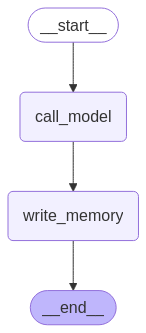

In [14]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [16]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful routes and views. Do you have any favorite trails or spots you like to visit while biking?


In [17]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful routes and views. Do you have any favorite trails or spots you like to visit while biking?


In [18]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "**Updated User Information:**\n- User's name is Lance.\n- Likes to bike around San Francisco."},
 'created_at': '2025-03-19T05:27:49.151659+00:00',
 'updated_at': '2025-03-19T05:27:49.151659+00:00'}

In [19]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi Lance! Biking around San Francisco offers some fantastic routes. Here are a few recommendations:

1. **Golden Gate Park**: This is a classic choice with plenty of trails and beautiful scenery. You can enjoy the lush greenery and even stop by the de Young Museum or the California Academy of Sciences.

2. **The Embarcadero**: Starting from AT&T Park, you can bike along the waterfront, passing the Ferry Building and continuing towards Fisherman's Wharf. It's a great way to enjoy the bay views.

3. **Marin Headlands**: If you're up for a bit of a challenge, you can cross the Golden Gate Bridge and explore the Marin Headlands. The views of the city and the ocean are breathtaking.

4. **Presidio**: This area offers a mix of forested trails and coastal views. You can explore the hi

In [20]:
# User input 
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

Absolutely, Lance! A croissant sounds like a perfect treat after a ride. Here are a few bakeries in San Francisco where you can find delicious croissants:

1. **Tartine Bakery**: Located in the Mission District, Tartine is famous for its pastries, and their croissants are a must-try.

2. **Arsicault Bakery**: Situated in the Richmond District, Arsicault has been praised for its buttery, flaky croissants. It's a bit of a ride from the city center, but worth the trip.

3. **b. Patisserie**: In Lower Pacific Heights, this bakery offers a variety of pastries, including some fantastic croissants. Their kouign-amann is also highly recommended.

4. **Le Marais Bakery**: With locations in the Marina and Castro, Le Marais offers a charming Fre